In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ticktack
from ticktack import fitting
import os
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

INFO[2022-01-25 13:49:26,837]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-01-25 13:49:26,838]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-01-25 13:49:26,839]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-01-25 13:49:26,840]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING[2022-01-25 13:50:25,352]: No handles with labels found to put in legend.
/tmp/ipykernel_27433/1836266710.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout();


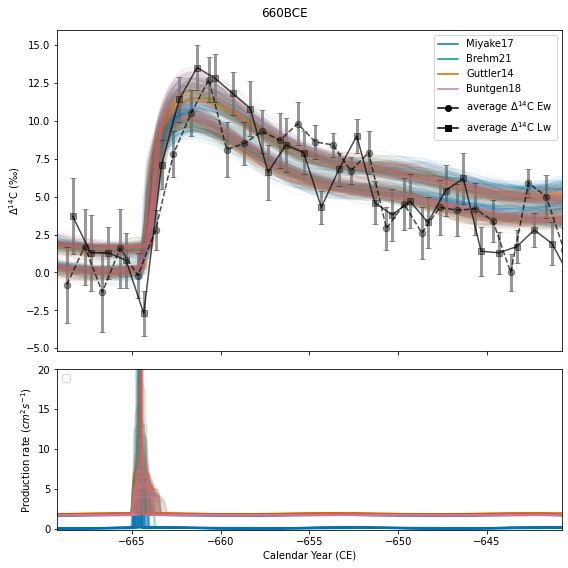

In [2]:
models = ["Miyake17", "Brehm21", "Guttler14", "Buntgen18"]
events = ["data/660BCE/Sakurai20_CedarEw.csv", "data/660BCE/Sakurai20_CedarLw.csv"]
H = ["north", "south"]
offsets = [4/12, 8/12]
# colors = ["g", "b", "r", "c"]
colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
fmts = [["ok", "--k"], ["sk", "-k"]]
size = 100
size2 = 30
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

for i, event in enumerate(events):
    for j, model in enumerate(models):
        cbm = ticktack.load_presaved_model(model, production_rate_units = 'atoms/cm^2/s')
        sf = fitting.SingleFitter(cbm, cbm_model=model, hemisphere=H[i])
        sf.load_data(event)
        chain = np.load("chain/660BCE_" + model + ".npy")
        nwalkers = chain.shape[1] * 2
        sf.compile_production_model(model="flexible_sinusoid_affine_variant")

        idx = np.random.randint(len(chain), size=size)
        params = np.zeros((size, chain[0].size))
        d14cs = np.zeros((size, sf.time_data_fine.size))
        params[:, :] = chain[idx]
        for k in range(size):
            dc14 = sf.dc14_fine(params=params[k, :])
            d14cs[k, :] = dc14

        for d14c in d14cs:
            ax1.plot(sf.time_data_fine + offsets[i], d14c, alpha=0.05, color=colors[j])
            
        ax1.set_ylabel("$\Delta^{14}$C (‰)")
        fig.subplots_adjust(hspace=0.05)

        for param in params[:size2]:
            production_rate = sf.production(sf.time_data_fine, *param)
            ax2.plot(sf.time_data_fine, production_rate, alpha=0.2, color=colors[j])
    
custom_lines = [Line2D([0], [0], color=colors[0], lw=1.5, label=models[0]),
                Line2D([0], [0], color=colors[1], lw=1.5, label=models[1]),
                Line2D([0], [0], color=colors[2], lw=1.5, label=models[2]), 
                Line2D([0], [0], color=colors[3], lw=1.5, label=models[3]), 
                Line2D([0], [0], color="k", marker="o", lw=1.5, label="average $\Delta^{14}$C Ew"), 
                Line2D([0], [0], color="k", marker="s", lw=1.5, label="average $\Delta^{14}$C Lw")]

for i in range(len(events)):
    cbm = ticktack.load_presaved_model(model, production_rate_units = 'atoms/cm^2/s')
    sf = fitting.SingleFitter(cbm, cbm_model=model, hemisphere=H[i])
    sf.load_data(events[i])
    ax1.errorbar(sf.time_data + offsets[i], sf.d14c_data, yerr=sf.d14c_data_error, fmt=fmts[i][0], capsize=3,
                 markersize=6.5, elinewidth=3, label="average $\Delta^{14}$C", alpha=0.4)
    ax1.plot(sf.time_data + offsets[i], sf.d14c_data, fmts[i][1], alpha=0.7)
    
ax1.legend(handles=custom_lines)
ax2.set_ylim(-0.1, 20);
ax2.set_xlabel("Calendar Year (CE)");
ax2.set_xlim(sf.start-0.2, sf.end+0.2);
ax2.set_ylabel("Production rate ($cm^2s^{-1}$)");
ax2.legend(loc="upper left")
plt.suptitle("660BCE");
plt.tight_layout();
plt.savefig("plots/overplots/660BCE-EwLw.jpg")